In [8]:
from stackapi import StackAPI
from langdetect import detect
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from nltk.corpus import stopwords
import nltk
from wordcloud import WordCloud
from gensim import corpora
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\milan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
def df_save(min_score=10, min_tags=4, max_tags=15, min_title_length=10, max_title_length=100, save_path="data_with_body.csv"):
    """
    Fetches questions from StackOverflow using the StackAPI, filters them based on 
    specified criteria, and saves the resulting data to a CSV file.

    Parameters:
    - min_score (int): Minimum score a question must have to be included. Default is 10.
    - min_tags (int): Minimum number of tags a question must have to be included. Default is 4.
    - max_tags (int): Maximum number of tags a question can have to be included. Default is 15.
    - min_title_length (int): Minimum length of the question title. Default is 10.
    - max_title_length (int): Maximum length of the question title. Default is 100.
    - save_path (str): File path where the data will be saved. Default is "data_with_body.csv".

    Functionality:
    - Attempts to continue data collection from an existing CSV file if found.
    - Fetches data from StackOverflow within a specified time range (2020-12-04 to 2024-10-20).
    - Filters the data based on the specified conditions.
    - Saves the filtered data incrementally into the provided file.

    Raises:
    - FileNotFoundError: If the file to resume from is not found.
    - Exception: For issues with the StackAPI or file writing.

    Returns:
    - None. The data is directly saved to the file specified in `save_path`.
    """
    SITE = StackAPI('stackoverflow')
    SITE.max_pages = 25
    SITE.page_size = 100
    
    try:
        df_existing = pd.read_csv(save_path)
        all_data = df_existing.to_dict('records')
        print(f"Reprise de la collecte. {len(df_existing)} lignes déjà récupérées.")
    except FileNotFoundError:
        all_data = []
    
    start_date = datetime.datetime(2020, 12, 4)
    end_date = datetime.datetime(2024, 10, 20)
    
    delta = datetime.timedelta(days=45)
    
    current_start = start_date
    
    while current_start < end_date:
        print("start")
        current_end = min(current_start + delta, end_date)

        fromdate = int(current_start.timestamp())
        todate = int(current_end.timestamp())
    
        try:

            questions = SITE.fetch('questions',
                                   fromdate=fromdate,
                                   todate=todate,
                                   min=min_score,
                                   sort='votes',
                                   filter='withbody'
                                   )
        except Exception as e:
            print(f"Error fetching questions from {current_start} to {current_end}: {e}")
            time.sleep(5)
            return
        
        data = []
        print("questions")
        for question in questions['items']:

            if (min_tags <= len(question.get('tags', [])) <= max_tags and
                min_title_length <= len(question.get('title', '')) <= max_title_length):
                data.append({
                    'title': question['title'],
                    'body': question['body'],
                    'score': question['score'],
                    'tags': ','.join(question['tags']),
                    'creation_date': datetime.datetime.fromtimestamp(question['creation_date']).isoformat(),
                })
        all_data.extend(data)
        print("extend")
        df_filtered = pd.DataFrame(all_data)
        df_filtered.to_csv(save_path, index=False)
        print(f"{len(data)} lignes récupérées de {current_start} à {current_end}.")
        print(f"{len(all_data)} lignes sauvegardées dans {save_path}.")       
    
        current_start = current_end
        time.sleep(0.2)


Possible Filter to get consistant data for tag prediction :
- By the score
- by the number of tags
- Temporality
- title(question) size
- by the popularity(view)
- language
- 

In [25]:
df = df_save()

Reprise de la collecte. 42076 lignes déjà récupérées.
start
questions
extend
658 lignes récupérées de 2020-12-04 00:00:00 à 2021-01-18 00:00:00.
42734 lignes sauvegardées dans data_with_body.csv.
start
questions
extend
717 lignes récupérées de 2021-01-18 00:00:00 à 2021-03-04 00:00:00.
43451 lignes sauvegardées dans data_with_body.csv.
start
questions
extend
636 lignes récupérées de 2021-03-04 00:00:00 à 2021-04-18 00:00:00.
44087 lignes sauvegardées dans data_with_body.csv.
start
questions
extend
529 lignes récupérées de 2021-04-18 00:00:00 à 2021-06-02 00:00:00.
44616 lignes sauvegardées dans data_with_body.csv.
start
questions
extend
492 lignes récupérées de 2021-06-02 00:00:00 à 2021-07-17 00:00:00.
45108 lignes sauvegardées dans data_with_body.csv.
start
questions
extend
402 lignes récupérées de 2021-07-17 00:00:00 à 2021-08-31 00:00:00.
45510 lignes sauvegardées dans data_with_body.csv.
start
questions
extend
490 lignes récupérées de 2021-08-31 00:00:00 à 2021-10-15 00:00:00.
460

We scrap our data now we can use it

In [26]:
df = pd.read_csv("data_with_body.csv")

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50019 entries, 0 to 50018
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          50019 non-null  object
 1   body           50019 non-null  object
 2   score          50019 non-null  int64 
 3   tags           50019 non-null  object
 4   creation_date  50019 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.9+ MB


In [28]:
df.describe()

,score
count,50019.000000
mean,45.590855
std,72.166168
min,10.000000
25%,17.000000
50%,28.000000
75%,47.000000
max,3252.000000


delete dup title

In [29]:
df.drop_duplicates('title', inplace=True)
df.duplicated('title').sum()

0

In [ ]:
class TextPreprocessor:
    """
    A class to preprocess text data for natural language processing tasks, including cleaning, 
    lemmatizing, and visualizing data from a DataFrame.

    Attributes:
    - df (pd.DataFrame): DataFrame containing the text data to preprocess.
    - commun (int): Number of most common words to exclude from the text. Default is 3.
    - stop_words (set): Standard English stopwords.
    - stop_words_strict (set): Custom stopword set for stricter cleaning (initialized as None).
    - lemmatizer (WordNetLemmatizer): Lemmatizer for reducing words to their base form.
    - less_common (list): Words appearing less frequently in the text.

    Methods:
    - is_english(text): Checks if the given text is in English.
    - clean_text(text): Cleans text by removing special characters and stopwords.
    - clean_text_strict(text): Cleans text using the strict stopword set.
    - clean_common(text, frequent_words): Removes frequent words from the text.
    - lemmatize_text(text): Lemmatizes words in the text.
    - clean_dl(text): Cleans text for deep learning purposes by lowercasing and removing non-alphabetic characters.
    - clean_df(): Prepares and cleans the DataFrame by applying various cleaning steps and filtering non-English entries.
    - transform(): Cleans the DataFrame and applies lemmatization, returning the processed DataFrame.
    - plot_WordCloud(): Generates a word cloud of the most frequent words in titles.
    - plot_words(column): Plots a bar chart of the most frequent words in a specified column.
    - take_words_not_common(): Identifies words appearing less than or equal to 10 times in the data.
    - get_less_common(): Returns the list of less common words.
    - add_stop_words(words): Adds custom words to the strict stopword set.
    - plot_tags(): Plots the top 30 most frequent tags in the data.
    - boxplot_scores(): Plots a boxplot of question scores in the DataFrame.
    - get_data(): Returns the processed DataFrame.
    """

    def __init__(self, df, commun=3):
        """
        Initializes the TextPreprocessor class.

        Parameters:
        - df (pd.DataFrame): DataFrame containing the text data to preprocess.
        - commun (int): Number of most common words to exclude from the text. Default is 3.
        """
        self.df = df
        self.stop_words = set(stopwords.words('english'))
        self.stop_words_strict = None
        self.lemmatizer = WordNetLemmatizer()
        self.commun = commun
        self.less_common = None

    def is_english(self, text):
        """Checks if the given text is in English."""
        try:
            return detect(text) == 'en'
        except:
            return False

    def clean_text(self, text):
        """Cleans text by removing special characters and standard stopwords."""
        text = text.lower()
        text = re.sub(r'(?<!\bc)(\+|#)', '', text)
        text = re.sub(r'[^a-z\s\+#]', '', text)
        words = text.split()
        words = [word for word in words if word not in self.stop_words]
        return ' '.join(words)
    
    def clean_text_strict(self, text):
        """Cleans text using a stricter stopword set."""
        text = text.lower()
        text = re.sub(r'(?<!\bc)(\+|#)', '', text)
        text = re.sub(r'[^a-z\s\+#]', '', text)
        words = text.split()
        words = [word for word in words if word not in self.stop_words_strict]
        return ' '.join(words)

    def clean_common(self, text, frequent_words):
        """Removes frequent words from the text."""
        words = text.split()
        words = [word for word in words if word not in frequent_words]
        return ' '.join(words)

    def lemmatize_text(self, text):
        """Lemmatizes words in the text."""
        words = text.split()
        lemmatized_words = [self.lemmatizer.lemmatize(word) for word in words]
        return ' '.join(lemmatized_words)

    def clean_dl(self, text):
        """Cleans text for deep learning purposes by lowercasing and removing non-alphabetic characters."""
        text = text.lower()
        text = re.sub(r'(?<!\bc)(\+|#)', '', text)
        text = re.sub(r'[^a-z\s\+#]', '', text)
        return text
    
    def clean_df(self):
        """Prepares and cleans the DataFrame by filtering non-English entries and applying cleaning steps."""
        self.df['is_english'] = self.df['title'].apply(self.is_english)
        self.df = self.df[self.df['is_english'] == True].copy()
        self.df.loc[:, 'cleaned_title'] = self.df['title'].apply(lambda x: self.clean_text(x))
        if self.stop_words_strict is not None:
            self.df.loc[:, 'cleaned_title_strict'] = self.df['title'].apply(lambda x: self.clean_text_strict(x))
        self.plot_words()
        all_words = [word for title in self.df['cleaned_title'].str.split() for word in title]
        words, counts = zip(*Counter(all_words).most_common(self.commun))
        print(words)
        self.df.loc[:, 'cleaned_title'] = self.df['cleaned_title'].apply(lambda x: self.clean_common(x, words))
        self.take_words_not_common()
        self.df.loc[:, 'cleaned_title'] = self.df['cleaned_title'].apply(lambda x: self.clean_common(x, self.less_common))
        if self.stop_words_strict is not None:
            self.df.loc[:, 'cleaned_title_strict'] = self.df['cleaned_title_strict'].apply(lambda x: self.clean_common(x, self.less_common))
        if self.stop_words_strict is not None:
            self.df.loc[:, 'cleaned_title_strict'] = self.df['cleaned_title_strict'].apply(lambda x: self.clean_common(x, words))
        self.df.loc[:, 'dl_title'] = self.df['title'].apply(lambda x: self.clean_dl(x))
        self.df.loc[:, 'dl_body'] = self.df['body'].apply(lambda x: self.clean_dl(x))
        self.plot_words()
    
    def transform(self):
        """Cleans the DataFrame and applies lemmatization, returning the processed DataFrame."""
        self.clean_df()
        self.df.loc[:, 'lm'] = self.df['cleaned_title'].apply(lambda x: self.lemmatize_text(x))
        return self.df
    
    def plot_WordCloud(self):
        """Generates a word cloud of the most frequent words in titles."""
        if 'cleaned_title' not in self.df.columns:
            all_words = [word for title in self.df['title'] \
                if isinstance(title, str) for word in title.split()]
        else:
            all_words = [word for title in self.df['cleaned_title'] \
                if isinstance(title, str) for word in title.split()]
        c = Counter(all_words)
        word_counts = {word: count for word, count in c.items()}
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud of Most Frequent Words in Titles', fontsize=16)
        plt.show()
        
    def plot_words(self, column='cleaned_title'):
        """Plots a bar chart of the most frequent words in a specified column."""
        if column not in self.df.columns:
            all_words = [word for title in self.df['title'].str.split() for word in title]
        else:
            all_words = [word for title in self.df[column].str.split() for word in title]
        words, counts = zip(*Counter(all_words).most_common(200))
        plt.figure(figsize=(40, 6))
        plt.bar(words, counts, color='skyblue')
        plt.title('Top 200 Most Frequent Words in Titles', fontsize=15)
        plt.ylabel('Frequency', fontsize=12)
        plt.xlabel('Words', fontsize=12)
        plt.xticks(rotation=90, ha='right', fontsize=10)
        plt.tight_layout()
        plt.show()

    def take_words_not_common(self):
        """Identifies words appearing less than or equal to 10 times in the data."""
        if 'cleaned_title' not in self.df.columns:
            all_words = [word for title in self.df['title'].str.split() for word in title]
        else:
            all_words = [word for title in self.df['cleaned_title'].str.split() for word in title]
        word_counts = Counter(all_words)
        self.less_common = [word for word, count in word_counts.items() if count <= 10]

    def get_less_common(self):
        """Returns the list of less common words."""
        return self.less_common
        
    def add_stop_words(self, words):
        """Adds custom words to the strict stopword set."""
        self.stop_words_strict = set(self.stop_words)
        self.stop_words_strict.update(words)
    
    def plot_tags(self):
        """Plots the top 30 most frequent tags in the data."""
        if 'tags_split' not in self.df.columns:
            self.df['tags_split'] = self.df['tags'].str.split(',')
        all_tags = [tag for sublist in self.df['tags_split'] for tag in sublist]
        tag_counts = pd.Series(all_tags).value_counts()
        plt.figure(figsize=(12, 6))
        tag_counts.head(30).plot(kind='bar')
        plt.title('Top 30 Most Frequent Tags')
        plt.ylabel('Frequency')
        plt.xlabel('Tags')
        plt.xticks(rotation=70)
        plt.tight_layout()
        plt.show()
        
    def boxplot_scores(self):
        """Plots a boxplot of question scores in the DataFrame."""
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=self.df, x='score')
        plt.title('Boxplot of Question Scores')
        plt.xlabel('Score')
        plt.show()

    def get_data(self):
        """Returns the processed DataFrame."""
        return self.df


In [33]:
TP = TextPreprocessor(df.copy())


New Stop word to make some tries

In [34]:
new_stopword = ['get', 'use', 'way', 'would', 'like', 'one', 'need', 'know', 'make', 'using', \
    'want', 'work', 'code', 'example', 'function', 'value', 'problem', 'user', 'data', 'file', 'time', \
    'set', 'return', 'string', 'method', 'class', 'object', 'found', 'type', 'run', 'try', 'new', 'create', \
    'two', 'call', 'spring', 'app', 'save', 'work', 'change', 'another', 'directory', 'used', 'testing', 'test', \
    'operator', 'open', 'update', 'variable', 'package', 'template', 'cant', 'check', 'version', 'resolve', 'null', \
    'memory', 'dependency', 'list', 'images', 'issue', 'packages', 'loading', 'row', 'rows', 'column', 'cannot', 'property', \
    'properties', 'doesnt', 'size', 'undefined', 'read', 'objects', 'typeerror', 'specific', 'default', 'table', 'library', 'fix', \
    'command', 'custom', 'service', 'functions', 'warning', 'whats', 'static', 'fails', 'text', 'permission', 'values', 'array', 'arrays', \
    'remove', 'name', 'find', 'unable', 'failed', 'could', 'query', 'tests', 'instance', 'response', 'order', 'creating', 'files', 'getting', \
    'via', 'input', 'local', 'exception', 'page', 'available', 'running', 'parameter', 'character', 'characters', 'possible', 'form', 'always', \
    'changes', 'group', 'post', 'correctly', 'show', 'path', 'arguments', 'constructor',  'target', 'compile', 'requests', 'project', 'pass', \
    'deprecated', 'instead', 'single', 'output', 'key', 'types', 'format', 'connection', 'date', 'support', 'debug', 'map', 'mode', 'tab', 'number', \
    'start', 'trying', 'configuration', 'build', 'image', 'based', 'working', 'color', 'attribute', 'index', 'multiple', 'showing', 'select', 'columns', \
    'updating', 'different', 'load', 'actions', 'expected', 'element', 'within', 'prevent', 'message', 'body', 'prevent', 'difference', 'import', \
    'missing', 'extension', 'send', 'download', 'content', 'add', 'core', 'access', 'remove', 'delete', 'click', 'display', 'check', 'passing', 'pass', \
    'module', 'modules', 'without', 'install', 'installed', 'access', 'inside', 'outside', 'convert', 'converts', 'material', 'line', 'lines', 'navigation', \
    'field', 'fields', 'button', 'buttons', 'event', 'events', 'variables', 'variable', 'properties', 'property', 'state', 'states', 'connect', 'connected', \
    'script', 'reference', 'screen', 'arguments', 'argument', 'parameter', 'parameters', 'background', 'backgrounds', 'store', 'stored', 'stores', 'store', \
    'adding', 'invalid', 'valid', 'validity', 'validate', 'validation', 'validating', 'validated', 'validates', 'validations', 'validation', 'dynamic', \
    'dynamically', 'folder', 'defined', 'define', 'context', 'installing', 'errors', 'current', 'empty', 'console', 'best', 'must', 'option', 'plugin' \
    'action', 'actions', 'source', 'id', 'generate', 'generating', 'generated', 'generates', 'handle', 'handling', 'handled', 'handles', 'elements', 'element', \
    'named', 'exist', 'exists', 'existing', 'unit', 'units', 'installed', 'implement', 'implements', 'implemented', 'implementing', 'implementations', 'implementation', \
    'called', 'detect', 'detects', 'detected', 'detecting', 'detectable', 'detectability', 'display', 'displays', 'displayed', 'displaying', 'displayable', 'displayability', \
    'header', 'headers', 'loop', 'loops', 'looped', 'looping', 'loopable', 'loopability', 'storage', 'storages', 'stored', 'storing', 'store', 'storeable', 'storeability', \
    'play', 'bar', 'unknown', 'setting', 'settings', 'set', 'settable', 'log', 'logs', 'icon', 'cache', 'caches', 'required', 'require', 'requires', 'requiring', 'requirement', \
    'modules', 'enable', 'enables', 'enabled', 'enabling', 'enablement', 'disable', 'disables', 'disabled', 'disabling', 'disablement', 'disableable', 'disableability', 'disablement', \
    'process', 'processes', 'processed', 'processing', 'processable', 'processability', 'processable', 'processability', 'processable', 'processability', 'processable', 'processability', \
    'task', 'dependencies', 'configure', 'child', 'specify', 'item', 'existing', 'height', 'width', 'length', 'size', 'color', 'colors', 'heights', 'widths', 'lengths', 'sizes', 'colors', \
    'returns', 'returning', 'returned', 'supported', 'supporting', 'supports', 'supportable', 'supportability', 'copy', 'copies', 'copied', 'copying', 'copyable', 'copyability', 'copyable'\
    'config', 'configs', 'configured', 'configuring', 'configurable', 'configurability', 'link', 'links', 'linked', 'linking', 'linkable', 'linkability', 'system', 'systems', 'equivalent',\
    'include', 'unexpected', 'back', 'next', 'push', 'filter', 'automatically', 'generic', 'even', 'status', 'every', 'search', 'setup', 'changing', 'solve', 'correct', 'already'  \
    'export', 'result', 'parent', 'login', 'expression', 'expressions', 'expressed', 'expressing', 'expressable', 'external', 'results', 'position', 'positions', 'positioned', 'positioning', \
    'avoid', 'tag', 'match', 'replace', 'release', 'layout', 'schema', 'slow', 'fast', 'quick', 'slowly', 'quickly', 'fastly', 'slowest', 'fastest', 'quickest', 'slowly', 'quickly', 'fastly', \
    'performance', 'stop', 'items', 'work', 'works', 'hide', 'v', "works", "record", "tools", "execute", "plugin", "behavior", "redirect", "style", "full", "changed", "failure", "apply", "architecture"\
    "preview", "limit", "share", "crashes", "contain", "denied", "base", "public", "dictionary", "config", "scrolling", "big", "put", "document", "force", "pages", "pdf", "separate", "range", "definition"\
    "created", "locally", "efficient", "hide", "large", "hooks", "credentials", "properly", "purpose", "internal", "causes", "end", "converting", "manually", "libraries", "font", "point" \
    "repository", "account", "shows", "notification", "keep", "inject", "cypress" , "hash", "upload", "export", "keys", "see", "long", "space", "main", "services", "clear", "callback", \
    "authentication", "auto", "autocomplete", "differences", "engine", "still", "additional", "video", "throws", "usage", "deployment", "reading", "assets", "prompt",\
    "architecture", "location", "exactly", "false", "faster", "black", "second", "true", "platform", "classes", "calling", "level", "wrong", "entity", "certain", "move", \
    "execution", "trigger", "website", "preview", "virtual", "simple", "verify", "pull", "projects", "debugging", "per", "statement", "split", "exit", "crash", "step", \
    "contains", "pod", "airflow", "vector", "left", "private", "right", "case", "issues", "attributes", "hint", "failing", "retrieve", "gateway", "matrix", "stream", "password", \
    "write", "standard", "definition", "syntax", "bottom", "signature", "fetch", "security", 'blob', "border", "gives", "block", "collection", "active", "align", "practice",\
    "boolean", "es", "condition", "isnt", "cause", "exclude", "graph", "reset", "remote", "groupby", "imported", "beta", "wait", "names", "timezone", "boolean", "scope", "last",\
    "previous", "view", "first", "entity", "combine", "await", "member", "execution", "vector", "observable", "idea", "shared", "pull", "resource", "latest", "numbers", "isnt", \
    "device", "coverage", "tags", "maps", "close", "review", "created", "calling", "take", "signature", "signed", "got", "exactly", "groupby", "datetime", "assign", "functional", \
    "opened", "activity", "definition"]
TP.add_stop_words(new_stopword)

We want to see the representation of the most commun words

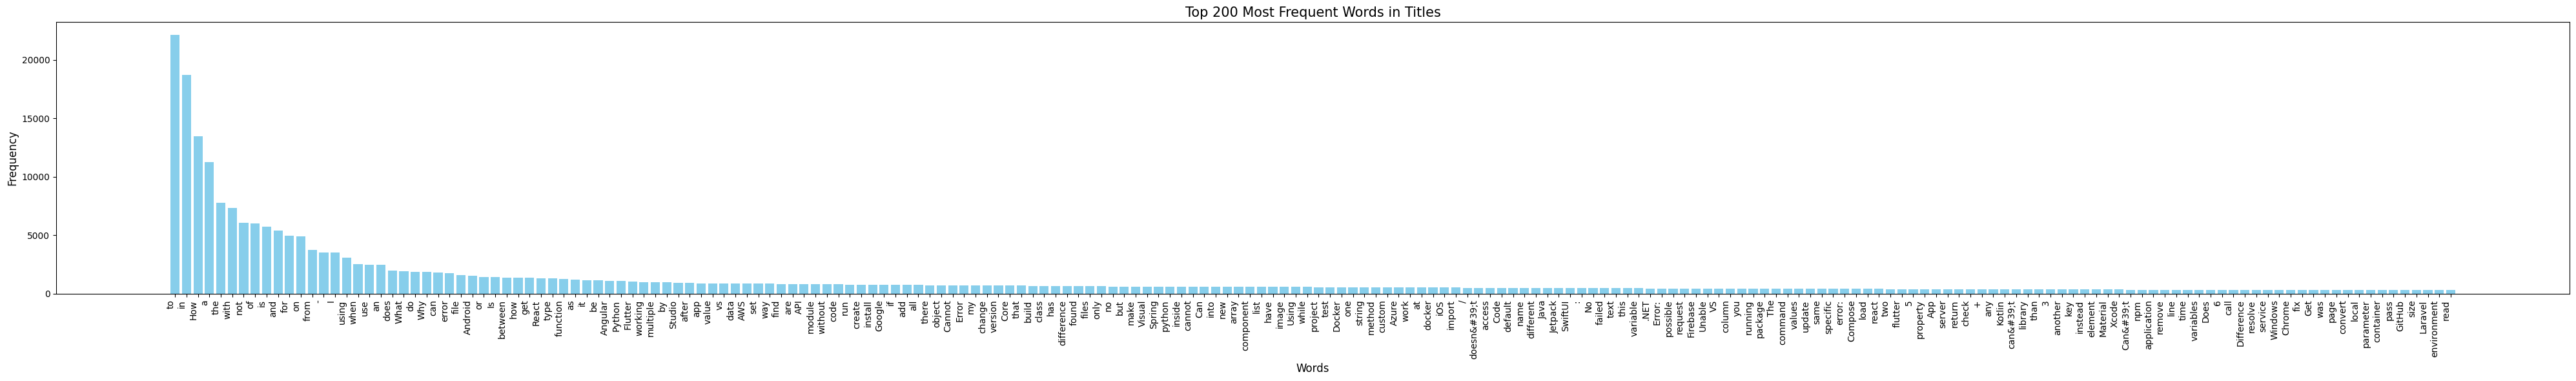

In [10]:
TP.plot_words()

Other way to see how words are represented

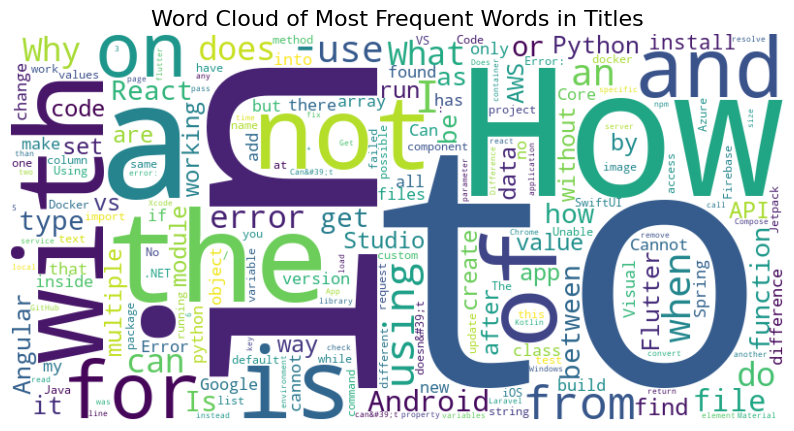

In [15]:
TP.plot_WordCloud()

Now I want to delete some useless words

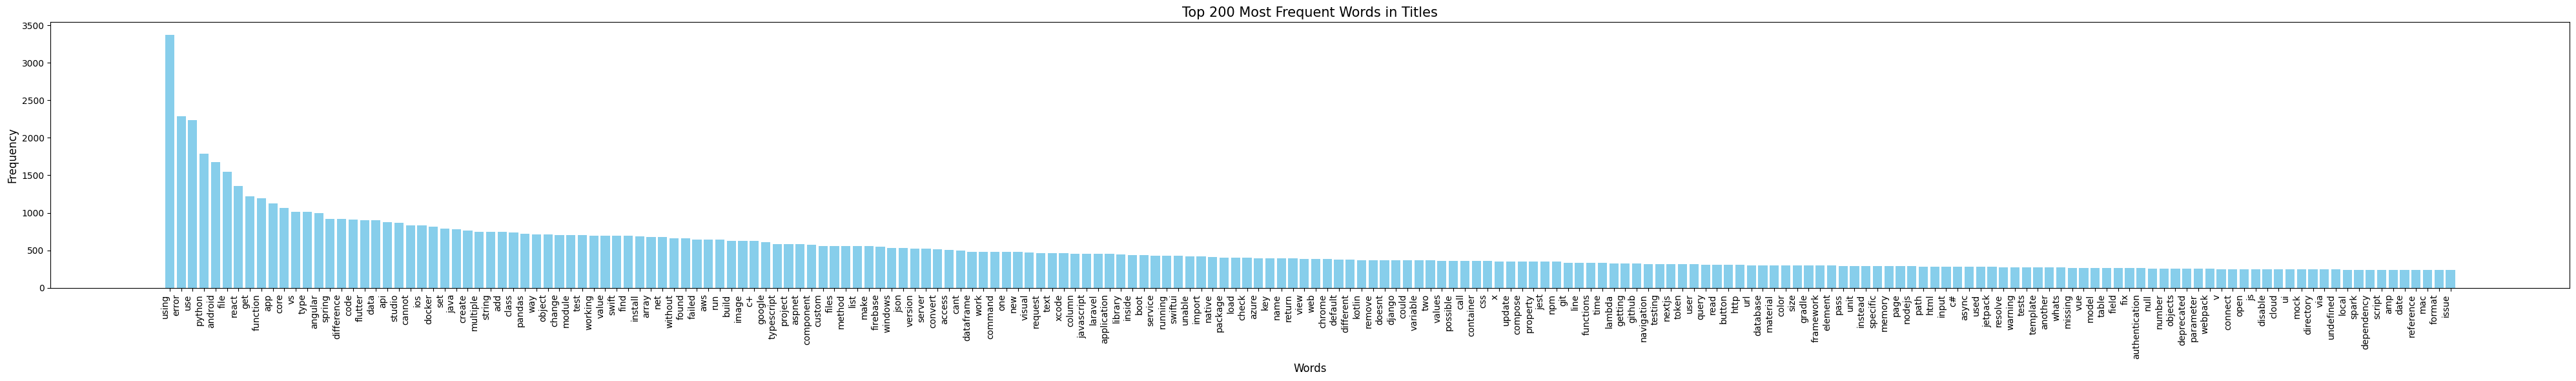

('using', 'error', 'use')


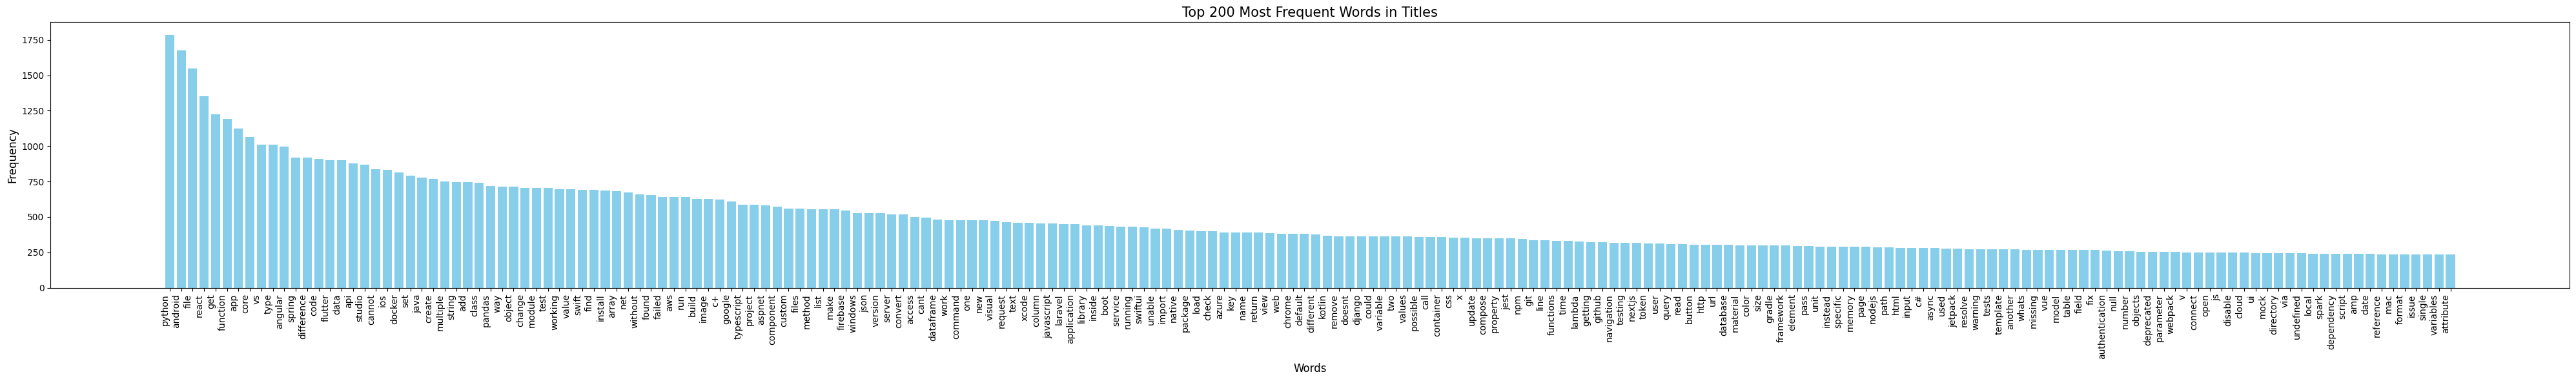

In [35]:
TP.transform()
print("\n")

With the New_stop word to obtain a strict clean to compare to normal clean

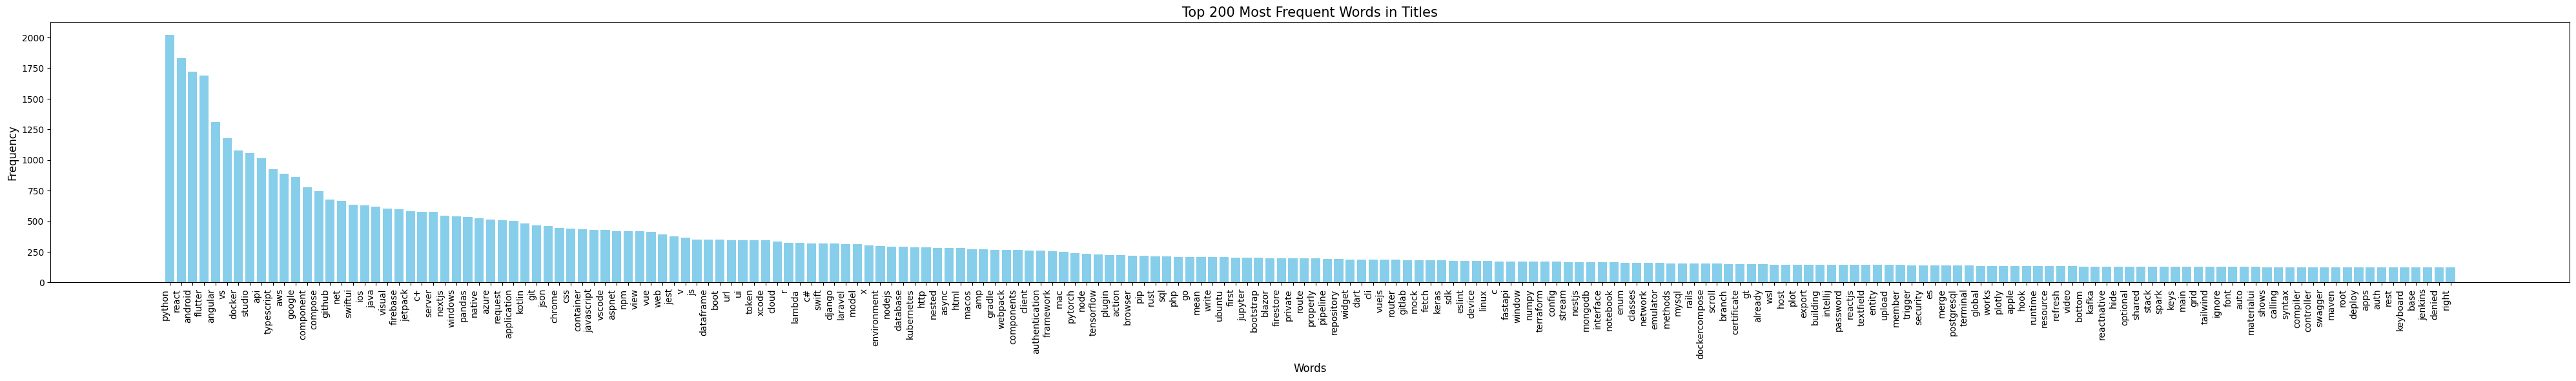

In [24]:
TP.plot_words('cleaned_title_strict')

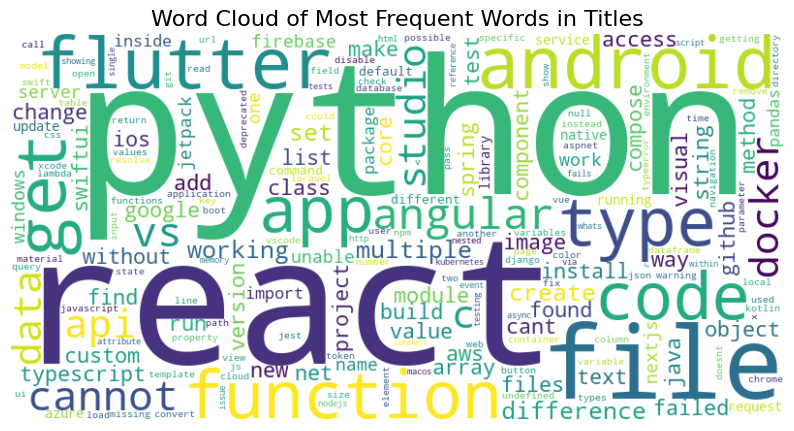

In [60]:
TP.plot_WordCloud()

Let's have a look of on the data

In [36]:
X_clean = TP.get_data()
X_clean.head()


,title,body,score,tags,creation_date,is_english,cleaned_title,cleaned_title_strict,dl_title,dl_body,lm
0,Use of PUT vs PATCH methods in REST API real l...,"<p>First of all, some definitions:</p>\n<p>PUT...",1308,"json,rest,http,put,http-method",2015-02-11T17:30:01,True,put vs patch methods rest api real life,vs patch methods rest api real life,use of put vs patch methods in rest api real l...,pfirst of all some definitionsp\npput is defin...,put v patch method rest api real life
1,React-router URLs don&#39;t work when refreshi...,<p>I'm using React-router and it works fine wh...,1288,"javascript,reactjs,url,react-router",2015-01-13T18:51:54,True,reactrouter urls dont work refreshing writing ...,reactrouter urls dont refreshing writing,reactrouter urls dont work when refreshing or ...,pim using reactrouter and it works fine while ...,reactrouter url dont work refreshing writing m...
2,How do I access previous promise results in a ...,"<p>I have restructured my code to <a href=""htt...",758,"javascript,scope,promise,bluebird,es6-promise",2015-01-31T11:41:29,True,access previous promise results chain,promise chain,how do i access previous promise results in a ...,pi have restructured my code to a hrefhttpsenw...,access previous promise result chain
3,How to create custom helper functions in Laravel,<p>I would like to create helper functions to ...,613,"php,laravel,laravel-8,laravel-blade,laravel-he...",2015-02-03T03:25:12,True,create custom helper functions laravel,helper laravel,how to create custom helper functions in laravel,pi would like to create helper functions to av...,create custom helper function laravel
4,Suppress InsecureRequestWarning: Unverified HT...,<p>I am writing scripts in Python2.6 with use ...,584,"python,python-2.6,suppress-warnings,urllib3,py...",2015-01-16T11:07:19,True,suppress https request made python,suppress https request made python,suppress insecurerequestwarning unverified htt...,pi am writing scripts in python with use of a ...,suppress http request made python


In [37]:
print(X_clean[X_clean['is_english'] == True].shape)

(46293, 11)


we have 46293 english elements

In [38]:
print(X_clean[X_clean['cleaned_title'].str.len() == 0].shape)
print(X_clean[X_clean['cleaned_title_strict'].str.len() == 0].shape)
X_clean = X_clean[X_clean['cleaned_title_strict'].str.len() >= 0].copy()

(256, 11)
(2886, 11)


Let's look the top 30 words

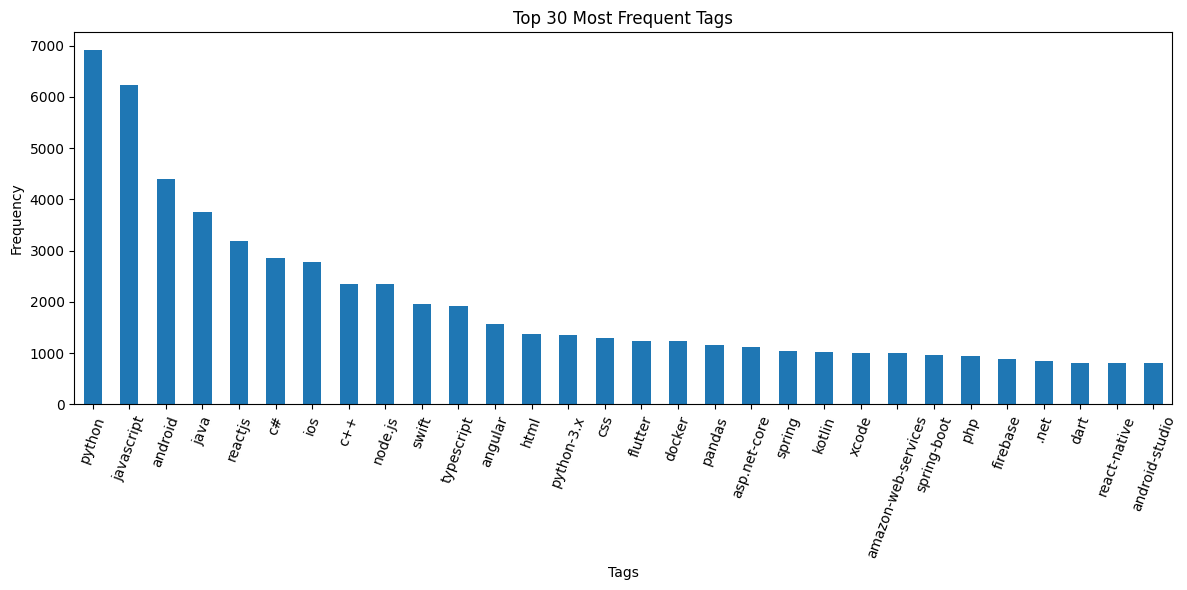

In [41]:
TP.plot_tags()

Creation of the file for next notebook

In [43]:
X_clean.to_csv("X_clean_with_body.csv")


In [44]:
print(X_clean.isna().sum())

title                   0
body                    0
score                   0
tags                    0
creation_date           0
is_english              0
cleaned_title           0
cleaned_title_strict    0
dl_title                0
dl_body                 0
lm                      0
dtype: int64
